# Training and Running of new GLM model
This Notebook is for training and running the our new GLM model that includes (for now only) deletion tokens

## Adding necessary imports
You can run this block to import necessary classes and functions

In [1]:
from fundemental_classes.model_related.glm_model import GLMModel

# You can change force_retrain to True if you want to always retrain your model everytime
model = GLMModel("./dna_bert_final",
                 "simulated_sequences/augumented_sequence_size10000_length60_deletions0.1_nodeletionseq0.25.fasta",
                 max_seq_length=200, force_retrain=False)

Initializing fresh model
No trained model loaded. Call train() to train the model.


## Training
We use `Bert` model to create the embeddings and train it using masking to get nicely trained model. If you want to change the size of training data, please look into `simulated_sequences` directory. \\\
*important:* Training is not necessary if you already have a trained model. You can load it using the `GLMModel`.

***** Running training *****
  Num examples = 698
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 440
  Number of trainable parameters = 8,620,042


Dataset split: 698 training, 174 validation
Starting Training


Step,Training Loss,Validation Loss


Saving model checkpoint to ./dna_bert_final/checkpoint-440
Configuration saved in ./dna_bert_final/checkpoint-440/config.json
Model weights saved in ./dna_bert_final/checkpoint-440/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./dna_bert_final/checkpoint-440/tokenizer_config.json
Special tokens file saved in ./dna_bert_final/checkpoint-440/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./dna_bert_final
Configuration saved in ./dna_bert_final/config.json
Model weights saved in ./dna_bert_final/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./dna_bert_final/tokenizer_config.json
Special tokens file saved in ./dna_bert_final/special_tokens_map.json
tokenizer config file saved in ./dna_bert_final/tokenizer_config.json
Speci

Saving model and tokenizer...
Training complete
Metadata saved to ./dna_bert_final/training_metadata.json
Training curves saved to ./dna_bert_final/training_curves.png


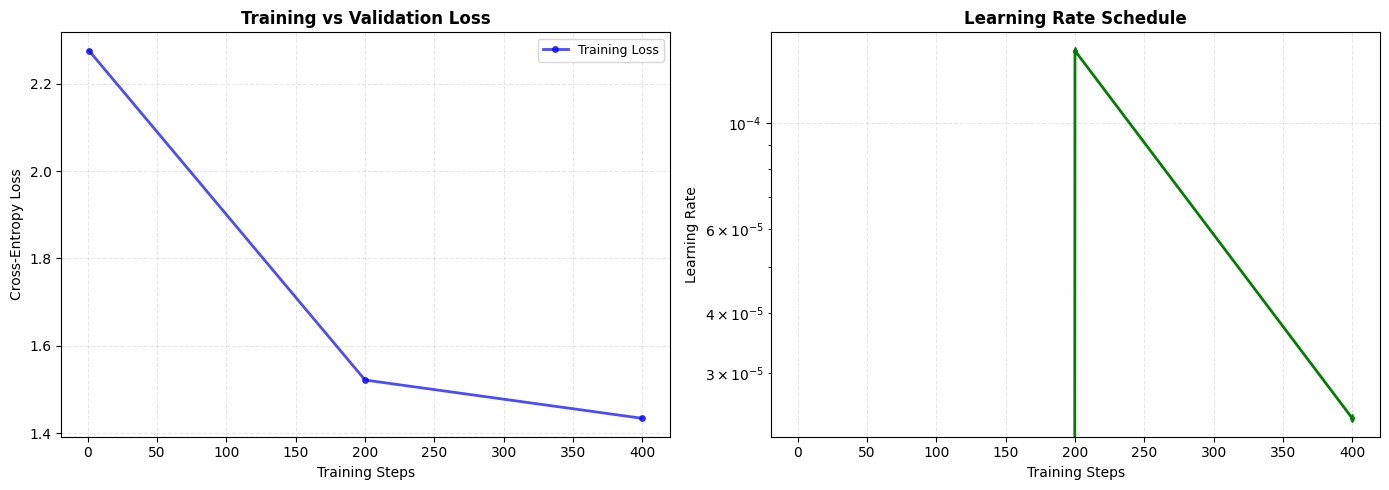


Training Summary:
Final training loss: 1.4337


In [2]:
model.train(epochs=10, batch_size=16, lr=2e-4, mlm_probability=0.25)

## Visualization
This block is used for getting already trained model, passing the sequence to test how well the model performs.
\\\\\
*Important:* For now we pass our test cases by hand. However in the future we will generate good inputs to test how well the model functions


--- Debug Info for position 0 ---
Original sequence: C-CCTGA-AAGGG-GGCGATC-CATTATTATGGGTACCGAAATGGAT-CTCTTTCTGTACAAT-CTTTG-TTTG-GGAAT-AGAAGGCAACAGATATTCAATCTCGCCA-CGTACTGCACCATGAAGG-TACT-GGG-CGTAACGGGAAG
Masked sequence:   [MASK]-CCTGA-AAGGG-GGCGATC-CATTATTATGGGTACCGAAATGGAT-CTCTTTCTGTACAAT-CTTTG-TTTG-GGAAT-AGAAGGCAACAGATATTCAATCTCGCCA-CGTACTGCACCATGAAGG-TACT-GGG-CGTAACGGGAAG
Original char at pos 0: 'C'
Token IDs: [4, 9, 6, 6, 8, 7, 5, 9, 5, 5, 7, 7, 7, 9, 7, 7, 6, 7, 5, 8, 6, 9, 6, 5, 8, 8, 5, 8, 8, 5, 8, 7, 7, 7, 8, 5, 6, 6, 7, 5, 5, 5, 8, 7, 7, 5, 8, 9, 6, 8, 6, 8, 8, 8, 6, 8, 7, 8, 5, 6, 5, 5, 8, 9, 6, 8, 8, 8, 7, 9, 8, 8, 8, 7, 9, 7, 7, 5, 5, 8, 9, 5, 7, 5, 5, 7, 7, 6, 5, 5, 6, 5, 7, 5, 8, 5, 8, 8, 6, 5, 5, 8, 6, 8, 6, 7, 6, 6, 5, 9, 6, 7, 8, 5, 6, 8, 7, 6, 5, 6, 6, 5, 8, 7, 5, 5, 7, 7, 9, 8, 5, 6, 8, 9, 7, 7, 7, 9, 6, 7, 8, 5, 5, 6, 7, 7, 7, 5, 5, 7]
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/home/tsartsidze/PycharmProjects/Sysgen-GLM-for-Indels/fundemental_classes/visualization/sequence_plotter.py:46: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


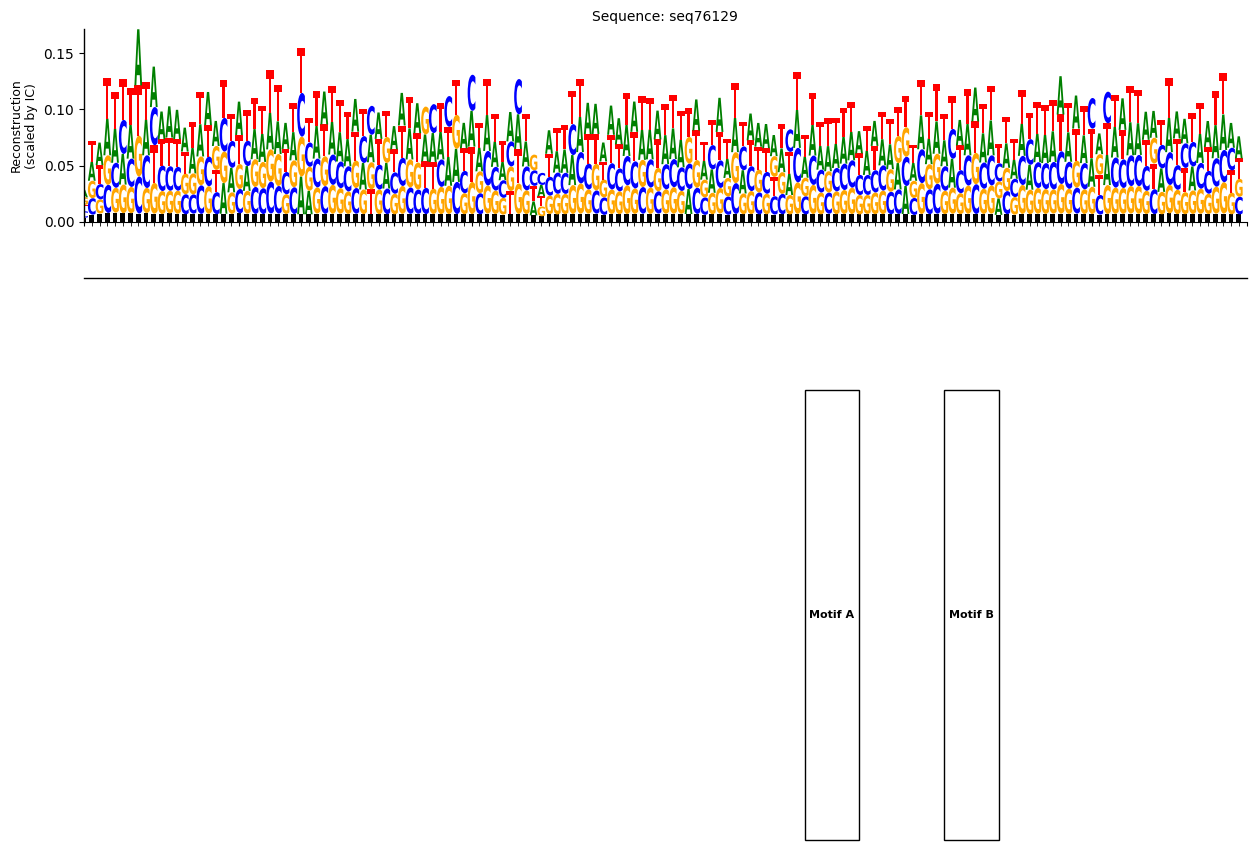

In [3]:
from fundemental_classes.visualization.sequence_plotter import plot

header = ">seq76129|label=both|posAmotif=93|posBmotif=111|gaplength=10|deletions=13"
sequence = "C-CCTGA-AAGGG-GGCGATC-CATTATTATGGGTACCGAAATGGAT-CTCTTTCTGTACAAT-CTTTG-TTTG-GGAAT-AGAAGGCAACAGATATTCAATCTCGCCA-CGTACTGCACCATGAAGG-TACT-GGG-CGTAACGGGAAG"

prob_matrix = model.get_full_reconstruction_probs(sequence, debug=True, dna_only=True)

plot(header, sequence, prob_matrix, motif_length=7)